In [19]:
import os
import librosa
import soundfile as sf
from scipy.signal import medfilt
import numpy as np
import matplotlib.pyplot as plt
import pywt

In [16]:
def wavelet_denoising(waveform, wavelet='db4', levels=5, threshold_mode='soft'):
    """
    使用小波变换进行信号去噪。

    参数:
    waveform (numpy.ndarray): 输入音频信号。
    wavelet (str): 小波基函数名称。
    levels (int): 分解层数。
    threshold_mode (str): 阈值处理模式，'soft' 或 'hard'。

    返回:
    numpy.ndarray: 去噪后的音频信号。
    """
    # 小波分解
    coeffs = pywt.wavedec(waveform, wavelet, level=levels)
    
    # 估计噪声标准差（使用最高频细节系数）
    sigma = np.median(np.abs(coeffs[-1])) / 0.6745
    
    # 计算阈值
    threshold = sigma * np.sqrt(2 * np.log(len(waveform)))
    
    # 对细节系数进行阈值处理
    coeffs_thresh = list(coeffs)
    coeffs_thresh[1:] = [pywt.threshold(detail, threshold, threshold_mode) 
                         for detail in coeffs[1:]]
    
    # 重构信号
    denoised_signal = pywt.waverec(coeffs_thresh, wavelet)
    
    return denoised_signal

In [4]:
def process_folder(input_folder, output_folder):
    # 确保输出文件夹存在，没有的话自动创建
    os.makedirs(output_folder, exist_ok=True)
    # 处理输入文件夹中的所有 WAV 文件
    for file in os.listdir(input_folder):
        if file.endswith(".wav"):
            input_file_path = os.path.join(input_folder, file)
            output_file_path = os.path.join(output_folder, file)
            # 执行去噪函数
            denoise(input_file_path, output_file_path)
            print(f"{file} processed and saved.")
        else:
            print(f"{file} is not a WAV file.")
    print("All files processed.")

In [13]:
def plot_waveform(waveform, sample_rate, title='Waveform'):
    """
    绘制音频波形。

    参数:
    waveform (numpy.ndarray): 音频信号，形状为 (n_samples,)。
    sample_rate (int): 音频采样率，单位为 Hz。
    title (str, optional): 图表标题，默认值为 'Waveform'。
    """
    # 计算时间轴
    time_scale = np.linspace(0, len(waveform) / sample_rate, len(waveform))

    # 绘制波形
    plt.figure(figsize=(12, 8))
    plt.plot(time_scale, waveform)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title(title)
    plt.show()

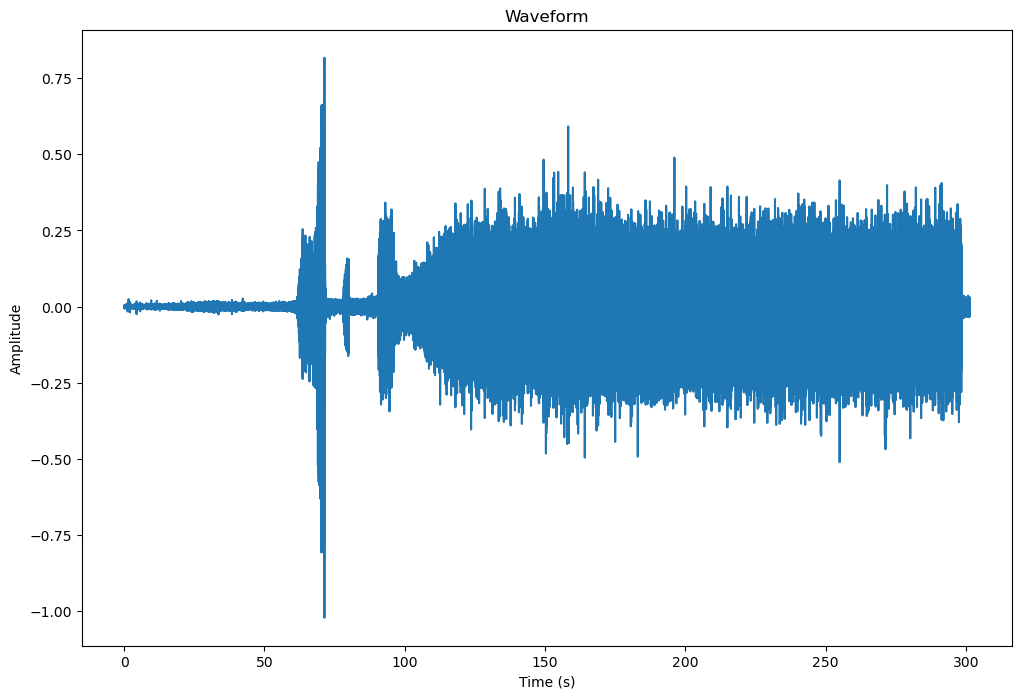

In [17]:
audio_file = r'E:\数据集\ShipEar\shipsEar_AUDIOS\6__10_07_13_marDeCangas_Entra.wav'
waveform, sample_rate = librosa.load(audio_file, sr=22050)

plot_waveform(waveform, sample_rate)

去噪前SNR: 6.70 dB
去噪后SNR: 8.13 dB
SNR改善: 1.43 dB


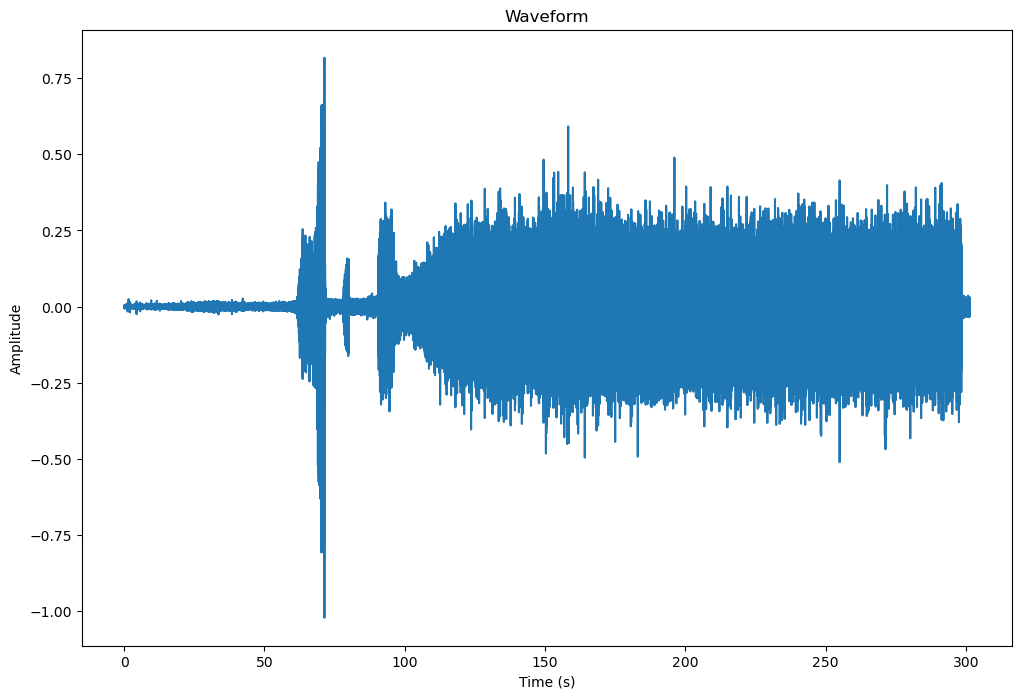

In [23]:
denoised_signal = wavelet_denoising(waveform, wavelet='db4', levels=5)

# 低频/高频阈值 500/2000 Hz，500 * N / 22050 ≈ N / 44.1，2000 * N / 22050 ≈ N / 11.1
snr_before = 10 * np.log10(np.mean(np.abs(np.fft.fft(waveform)[:len(waveform)//44])**2) / np.mean(np.abs(np.fft.fft(waveform)[len(waveform)//11:])**2))
snr_after = 10 * np.log10(np.mean(np.abs(np.fft.fft(denoised_signal)[:len(denoised_signal)//44])**2) / np.mean(np.abs(np.fft.fft(denoised_signal)[len(denoised_signal)//11:])**2))

print(f'去噪前SNR: {snr_before:.2f} dB')
print(f'去噪后SNR: {snr_after:.2f} dB')
print(f'SNR改善: {snr_after - snr_before:.2f} dB')

plot_waveform(waveform, sample_rate)

In [6]:
# 替换为输入和输出文件夹路径
input_folder = r"E:\数据集\ShipEar\shipsEar_AUDIOS"
output_folder = r"E:\数据集\ShipEar\data_preprocessing\audio_noise_reduction"

In [ ]:
# 处理整个文件夹中的所有文件
process_folder(input_folder, output_folder)